# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import uniform
from datetime import datetime
from scipy.stats import randint

from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier




% matplotlib inline
pd.set_option('display.max_columns', None)

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Exploration

All three datasets are studied, cleaned and simplified to help visualize trends. 
The data is then merged into one complete dataframe which is grouped by customer ids. This dataframe is to be used for visualization. Another dataframe contains the events which indicates how successful an offer was. This will be used to build our ML models.

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
def clean_portfolio(portfolio):

    cleaned_portfolio = portfolio.copy()
    # change the duration from day to hour to match other dataframes
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    # Change id to offer_id
    cleaned_portfolio.rename(columns={'id':'offer_id'}, inplace=True)
    
    # Change the offer ids to a simplied form
    offer_id = {'ae264e3637204a6fb9bb56bc8210ddfd': 'BOGO1',     # [email, mobile, social]
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'BOGO2',     # All channels
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'BOGO3',     # [web, email, mobile]
                'f19421c1d4aa40978ebb69ca19b0e20d': 'BOGO4',     # All channels
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'DISCOUNT1', # [web, email]
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'DISCOUNT2', # All channels
                'fafdcd668e3743c1bb461111dcafc2a4': 'DISCOUNT3', # All channels
                '2906b810c7d4411798c6938adc9daaa5': 'DISCOUNT4', # [web, email, mobile]
                '3f207df678b143eea3cee63160fa8bed': 'INFO1',
                '5a8bc65990b245e5a138643cd4eb9837': 'INFO2'}
    cleaned_portfolio.offer_id = cleaned_portfolio.offer_id.apply(lambda x: offer_id[x] if x else None)

    return cleaned_portfolio

In [4]:
cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,BOGO1,bogo,10,0,1,1,1,1,0,0
1,10,120,BOGO2,bogo,10,1,1,1,1,1,0,0
2,0,96,INFO1,informational,0,1,1,1,0,0,0,1
3,5,168,BOGO3,bogo,5,1,1,1,0,1,0,0
4,20,240,DISCOUNT1,discount,5,1,1,0,0,0,1,0
5,7,168,DISCOUNT2,discount,3,1,1,1,1,0,1,0
6,10,240,DISCOUNT3,discount,2,1,1,1,1,0,1,0
7,0,72,INFO2,informational,0,0,1,1,1,0,0,1
8,5,120,BOGO4,bogo,5,1,1,1,1,1,0,0
9,10,168,DISCOUNT4,discount,2,1,1,1,0,0,1,0


In [5]:
print(profile.head())
print()
print('Profile dataset shape: ' + str(profile.shape))
print()
print('Nulls: ') 
print(profile.isna().sum(axis=0)) # Nulls to be dropped

   age  became_member_on gender                                id    income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783       NaN
1   55          20170715      F  0610b486422d4921ae7d2bf64640c50b  112000.0
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5       NaN
3   75          20170509      F  78afa995795e4d85b5d9ceeca43f5fef  100000.0
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43       NaN

Profile dataset shape: (17000, 5)

Nulls: 
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


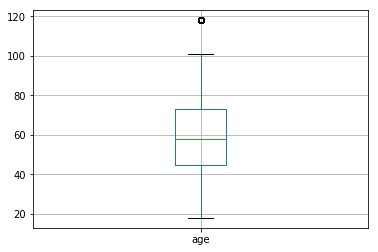

In [6]:
# Age distribution
profile.boxplot(column=['age'])

## Outliers in profile
The histogram above inidicates ages greater than 110 falls outside the norm. Upon further exploration these data rows also contain nulls which can be taken out of the dataset.

In [7]:
# Outliers
print('Outlier analysis')
outliers_profile = profile[profile.age > 110]
print(outliers_profile.head())
outliers_profile.isna().sum(axis=0) # All outliers are for age 118

Outlier analysis
   age  became_member_on gender                                id  income
0  118          20170212   None  68be06ca386d4c31939f3a4f0e3dd783     NaN
2  118          20180712   None  38fe809add3b4fcf9315a9694bb96ff5     NaN
4  118          20170804   None  a03223e636434f42ac4c3df47e8bac43     NaN
6  118          20170925   None  8ec6ce2a7e7949b1bf142def7d0e0586     NaN
7  118          20171002   None  68617ca6246f4fbc85e91a2a49552598     NaN


age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

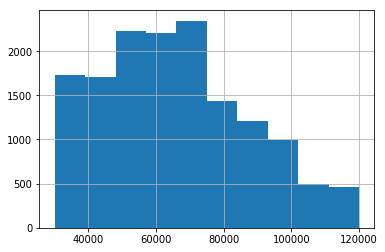

In [8]:
# Income distribution
profile.income.hist()

In [9]:
def clean_profile(profile):
    """ Clean the profile dataset.
    - Fix the date format
    - Change the column name id to customer_id
    - Create column to identify customers with demographic data
    - Add dummy columns for gender
    Input:
    - profile: original dataset
    Returns:
    - profile_clean
    """
    cleaned_profile = profile.copy()
    date_format_1 = lambda x: pd.to_datetime(str(x), format='%Y %m %d')  # Transform date from int to datetime
    date_format_2 = lambda x: pd.to_datetime(str(x), format='%Y %m %d').strftime('%Y-%m')  # Transform date from int to datetime

    cleaned_profile['became_member_on_year_month'] = cleaned_profile.became_member_on.apply(date_format_2)
    cleaned_profile.became_member_on = cleaned_profile.became_member_on.apply(date_format_1)
    cleaned_profile['became_member_on_year'] = pd.DatetimeIndex(cleaned_profile['became_member_on']).year
    cleaned_profile['became_member_on_month'] = pd.DatetimeIndex(cleaned_profile['became_member_on']).month
    cleaned_profile['outlier'] = (cleaned_profile.age == 118).astype(int) # Flag outliers
    
    # Change the name of id column to customer_id
    cleaned_profile.rename(columns={'id':'customer_id'}, inplace=True)
    # Create dummy columns for the gender column
    dummy_gender = pd.get_dummies(cleaned_profile.gender, prefix="gender")
    cleaned_profile = pd.concat([cleaned_profile, dummy_gender], axis=1, sort=False)
    cleaned_profile = cleaned_profile[['customer_id', 'age', 'gender', 'gender_F', 'gender_M', 'gender_O', 
                                      'became_member_on', 'became_member_on_year_month', 'became_member_on_year', 'became_member_on_month',
                                      'income', 'outlier']]
    return cleaned_profile

In [10]:
cleaned_profile = clean_profile(profile)
valid_cleaned_profile = cleaned_profile[cleaned_profile['outlier'] == 0]
valid_cleaned_profile.head()

,customer_id,age,gender,gender_F,gender_M,gender_O,became_member_on,became_member_on_year_month,became_member_on_year,became_member_on_month,income,outlier
1,0610b486422d4921ae7d2bf64640c50b,55,F,1,0,0,2017-07-15,2017-07,2017,7,112000.0,0
3,78afa995795e4d85b5d9ceeca43f5fef,75,F,1,0,0,2017-05-09,2017-05,2017,5,100000.0,0
5,e2127556f4f64592b11af22de27a7932,68,M,0,1,0,2018-04-26,2018-04,2018,4,70000.0,0
8,389bc3fa690240e798340f5a15918d5c,65,M,0,1,0,2018-02-09,2018-02,2018,2,53000.0,0
12,2eeac8d8feae4a8cad5a6af0499a211d,58,M,0,1,0,2017-11-11,2017-11,2017,11,51000.0,0


In [11]:
print('Transcript:')
print(transcript.head())
print()
print('Transcript df shape: ' + str(transcript.shape))
print('Transcript data count by event')
print(transcript.groupby('event').sum())
print()
print('Nulls: ') 
print(transcript.isna().sum(axis=0)) # No nulls

Transcript:
            event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}  

Transcript df shape: (306534, 4)
Transcript data count by event
                     time
event                    
offer completed  13466952
offer received   25368168
offer viewed     20451420
transaction      53022288

Nulls: 
event     0
person    0
time      0
value     0
dtype: int64


In [12]:
def clean_transcript(transcript):

    transcript_clean = transcript.copy()
    
    # Split event into several dummy columns
    transcript_clean.event = transcript_clean.event.str.replace(' ', '_')
    dummy_event = pd.get_dummies(transcript_clean.event, prefix="event")
    transcript_clean = pd.concat([transcript_clean, dummy_event], axis=1,
                                 sort=False)
    #transcript_clean.drop(columns='event', inplace=True)
    # Get the offer_id data from the value column
    transcript_clean['offer_id'] = [[*v.values()][0]
                                    if [*v.keys()][0] in ['offer id',
                                                          'offer_id'] else None
                                    for v in transcript_clean.value]
    # Change the offer ids to a simplied form
    offer_id = {'ae264e3637204a6fb9bb56bc8210ddfd': 'BOGO1',     # [email, mobile, social]
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 'BOGO2',     # All channels
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'BOGO3',     # [web, email, mobile]
                'f19421c1d4aa40978ebb69ca19b0e20d': 'BOGO4',     # All channels
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'DISCOUNT1', # [web, email]
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 'DISCOUNT2', # All channels
                'fafdcd668e3743c1bb461111dcafc2a4': 'DISCOUNT3', # All channels
                '2906b810c7d4411798c6938adc9daaa5': 'DISCOUNT4', # [web, email, mobile]
                '3f207df678b143eea3cee63160fa8bed': 'INFO1',
                '5a8bc65990b245e5a138643cd4eb9837': 'INFO2'}
    transcript_clean.offer_id = transcript_clean.offer_id.apply(lambda x: offer_id[x] if x else None)
    
    # Get the transaction amount data from the value column
    transcript_clean['amount'] = [np.round([*v.values()][0], decimals=2)
                                  if [*v.keys()][0] == 'amount' else None
                                  for v in transcript_clean.value]
    transcript_clean.drop(columns='value', inplace=True)
    # Change the name of person column to customer_id
    transcript_clean.rename(columns={'person':'customer_id'}, inplace=True)
    return transcript_clean

In [13]:
cleaned_transcript = clean_transcript(transcript)
print('Data shape: ' + str(cleaned_transcript.shape))
cleaned_transcript.head(8)

Data shape: (306534, 9)


,event,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,BOGO3,NaN
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,DISCOUNT1,NaN
2,offer_received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,DISCOUNT4,NaN
3,offer_received,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,DISCOUNT3,NaN
4,offer_received,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,BOGO2,NaN
5,offer_received,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,BOGO4,NaN
6,offer_received,c4863c7985cf408faee930f111475da3,0,0,1,0,0,DISCOUNT2,NaN
7,offer_received,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,INFO1,NaN


In [14]:
# Study a sample customer
sample_customer = cleaned_transcript['customer_id'] == '78afa995795e4d85b5d9ceeca43f5fef'
sample_customer_transcript = cleaned_transcript[sample_customer]
sample_customer_transcript

,event,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,BOGO3,NaN
15561,offer_viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,BOGO3,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,None,19.89
47583,offer_completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,BOGO3,NaN
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,None,17.78
53176,offer_received,78afa995795e4d85b5d9ceeca43f5fef,168,0,1,0,0,INFO2,NaN
85291,offer_viewed,78afa995795e4d85b5d9ceeca43f5fef,216,0,0,1,0,INFO2,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,0,0,0,1,None,19.67
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,0,0,0,1,None,29.72
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,0,0,0,1,None,23.93


In [15]:
# Study Popular offers
offer_completed = cleaned_transcript['event_offer_completed'] == 1
offer_completed_transcript = cleaned_transcript[offer_completed]
offer_stats = cleaned_transcript.groupby('offer_id').sum()
offer_stats = offer_stats.drop(['time', 'event_transaction', 'amount', 'event_offer_received'], axis=1)
offer_stats

,event_offer_completed,event_offer_viewed
offer_id,,
BOGO1,3688.0,6716.0
BOGO2,3331.0,7298.0
BOGO3,4354.0,4171.0
BOGO4,4296.0,7264.0
DISCOUNT1,3420.0,2663.0
DISCOUNT2,5156.0,7337.0
DISCOUNT3,5317.0,7327.0
DISCOUNT4,4017.0,4118.0
INFO1,0.0,4144.0


'\nOverall, discount offers have a higher degree of completion especially when communicated over all channels - [web, email, mobile, social].\nAlso, advertising over socials proves to have better customer views as suggested by data on BOGO3 and DISCOUNT1.\nThese were not viewed by many customers.\n'

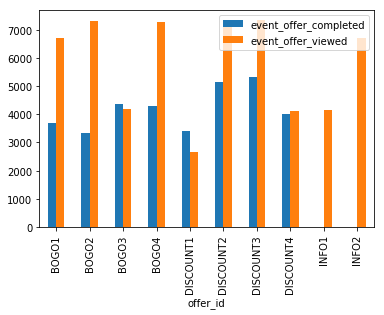

In [16]:
offer_stats.plot(kind='bar')
'''
Overall, discount offers have a higher degree of completion especially when communicated over all channels - [web, email, mobile, social].
Also, advertising over socials proves to have better customer views as suggested by data on BOGO3 and DISCOUNT1.
These were not viewed by many customers.
'''

In [17]:
# Calculate offer success
def calculate_success(portfolio_clean, profile_clean, transcript_clean):
    
    # Calculate success rate
    transaction_df = transcript_clean[transcript_clean.event == 'transaction'].copy()
    offers_df = transcript_clean[transcript_clean.event != 'transaction'].copy()
    
    customer_ids = offers_df['customer_id'].unique()
    
    success_data = []

    for ind in tqdm(range(len(customer_ids))):
        # get customer id from the list
        cust_id = customer_ids[ind]
        
        # extract customer profile from profile data
        customer = profile_clean[profile_clean['customer_id'] == cust_id]
        
        # extract offers associated with the customer from offers_df
        cust_offer_data = offers_df[offers_df['customer_id'] == cust_id]
        
        # extract transactions associated with the customer from transactions_df
        cust_transaction_data = transaction_df[transaction_df['customer_id'] == cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['event_offer_received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['event_offer_completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['event_offer_viewed'] == 1]
        
        rows = []
        
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio_clean.loc[portfolio_clean['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'customer_id': cust_id,
                'time': start_time,
                'event_offer_successful': int(offer_successful)
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())
            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        success_data.extend(rows)
        
    success_df = pd.DataFrame(success_data)
    return success_df

In [18]:
success_data = calculate_success(cleaned_portfolio, cleaned_profile, cleaned_transcript);

100%|██████████| 16994/16994 [17:58<00:00, 15.75it/s]


In [19]:
success_data.head()

,age,became_member_on,became_member_on_month,became_member_on_year,became_member_on_year_month,bogo,customer_id,difficulty,discount,duration,email,event_offer_successful,gender,gender_F,gender_M,gender_O,income,informational,mobile,offer_id,offer_type,outlier,reward,social,time,web
0,75,2017-05-09,5,2017,2017-05,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,168,1,1,F,1,0,0,100000.0,0,1,BOGO3,bogo,0,5,0,0,1
1,75,2017-05-09,5,2017,2017-05,0,78afa995795e4d85b5d9ceeca43f5fef,0,0,72,1,0,F,1,0,0,100000.0,1,1,INFO2,informational,0,0,1,168,0
2,75,2017-05-09,5,2017,2017-05,1,78afa995795e4d85b5d9ceeca43f5fef,10,0,168,1,1,F,1,0,0,100000.0,0,1,BOGO1,bogo,0,10,1,408,0
3,75,2017-05-09,5,2017,2017-05,1,78afa995795e4d85b5d9ceeca43f5fef,5,0,120,1,1,F,1,0,0,100000.0,0,1,BOGO4,bogo,0,5,1,504,1
4,118,2017-08-04,8,2017,2017-08,0,a03223e636434f42ac4c3df47e8bac43,20,1,240,1,0,None,0,0,0,NaN,0,0,DISCOUNT1,discount,1,5,0,0,1


In [20]:
# Filter outliers
valid_success_data = success_data[success_data['outlier'] == 0]

stripped_success_data = valid_success_data[['customer_id', 'event_offer_successful']]

# valid_success_data[['customer_id', 'offer_id' ,'event_offer_successful']].head()
success_per_customer = stripped_success_data.groupby('customer_id', as_index=False).sum()
print('Data shape: ' + str(success_per_customer.shape)) #3197
print('Unsuccessful offer count: ' + str(success_per_customer[success_per_customer['event_offer_successful'] == 0].shape)) #3197

success_per_customer.head()

Data shape: (14820, 2)
Unsuccessful offer count: (3197, 2)


,customer_id,event_offer_successful
0,0009655768c64bdeb2e877511632db8f,3
1,0011e0d4e6b944f998e987f904e8c1e5,3
2,0020c2b971eb4e9188eac86d93036a77,3
3,0020ccbbb6d84e358d3414a3ff76cffd,3
4,003d66b6608740288d6cc97a6903f4f0,3


In [21]:
# Sanity Check
valid_success_data[valid_success_data['customer_id'] == '2eeac8d8feae4a8cad5a6af0499a211d']

,age,became_member_on,became_member_on_month,became_member_on_year,became_member_on_year_month,bogo,customer_id,difficulty,discount,duration,email,event_offer_successful,gender,gender_F,gender_M,gender_O,income,informational,mobile,offer_id,offer_type,outlier,reward,social,time,web
32,58,2017-11-11,11,2017,2017-11,0,2eeac8d8feae4a8cad5a6af0499a211d,0,0,96,1,0,M,0,1,0,51000.0,1,1,INFO1,informational,0,0,0,0,1
33,58,2017-11-11,11,2017,2017-11,0,2eeac8d8feae4a8cad5a6af0499a211d,7,1,168,1,0,M,0,1,0,51000.0,0,1,DISCOUNT2,discount,0,3,1,168,1
34,58,2017-11-11,11,2017,2017-11,0,2eeac8d8feae4a8cad5a6af0499a211d,10,1,240,1,1,M,0,1,0,51000.0,0,1,DISCOUNT3,discount,0,2,1,336,1


In [22]:
def merge_datasets(portfolio_clean, profile_clean, transcript_clean):
    
    merge_1 = pd.merge(transcript_clean, profile_clean, on='customer_id', how="left")
    merged_data = pd.merge(merge_1, portfolio_clean, on='offer_id', how='left');
    
    return merged_data

In [23]:
data = merge_datasets(cleaned_portfolio, cleaned_profile, cleaned_transcript)

# Clean up outliers
data = data[data['outlier'] == 0]
print('Data Shape: ' + str(data.shape))
data.head()

Data Shape: (272762, 31)


,event,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,age,gender,gender_F,gender_M,gender_O,became_member_on,became_member_on_year_month,became_member_on_year,became_member_on_month,income,outlier,difficulty,duration,offer_type,reward,web,email,mobile,social,bogo,discount,informational
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,BOGO3,NaN,75,F,1,0,0,2017-05-09,2017-05,2017,5,100000.0,0,5.0,168.0,bogo,5.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
2,offer_received,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,DISCOUNT4,NaN,68,M,0,1,0,2018-04-26,2018-04,2018,4,70000.0,0,10.0,168.0,discount,2.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
5,offer_received,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,BOGO4,NaN,65,M,0,1,0,2018-02-09,2018-02,2018,2,53000.0,0,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
7,offer_received,2eeac8d8feae4a8cad5a6af0499a211d,0,0,1,0,0,INFO1,NaN,58,M,0,1,0,2017-11-11,2017-11,2017,11,51000.0,0,0.0,96.0,informational,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
8,offer_received,aa4862eba776480b8bb9c68455b8c2e1,0,0,1,0,0,DISCOUNT1,NaN,61,F,1,0,0,2017-09-11,2017-09,2017,9,57000.0,0,20.0,240.0,discount,5.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [24]:
def generate_customer_offer_type_map(df, offer_type=None):
    """
    Get offer data (received, viewed and completed) per customer and
    offer type
    Inputs:
    - df: dataframe of merged transactions, portfolio and profile data
    - offer_type: informational, bogo or discount
    Output:
    - aggregated data per customer and offer type
    """
    data = dict()
    
    for k in ['received', 'viewed', 'completed']:
        # Informational offers don't have completed data
        if offer_type == 'informational' and (k == 'completed'):
            continue
        flag = (df['event_offer_{}'.format(k)] == 1)
        key = k
        if offer_type:
            flag = flag & (df.offer_type == offer_type)
            key = '{}_'.format(offer_type) + key
        data[key] = df[flag].groupby('customer_id').offer_id.count()
    # Informational offers don't have reward data
    flag = (df.event_offer_completed == 1)
    if offer_type != 'informational':
        key = 'reward'
        if offer_type:
            flag = flag & (df.offer_type == offer_type)
            key = '{}_'.format(offer_type) + key
        data[key] = df[flag].groupby('customer_id').reward.sum()

    return data

In [25]:
customer_offer_map = generate_customer_offer_type_map(data, 'discount')
customer_offer_map['discount_completed'].head()

customer_id
0009655768c64bdeb2e877511632db8f    2
0011e0d4e6b944f998e987f904e8c1e5    2
0020c2b971eb4e9188eac86d93036a77    2
0020ccbbb6d84e358d3414a3ff76cffd    1
003d66b6608740288d6cc97a6903f4f0    3
Name: offer_id, dtype: int64

In [26]:
def generate_customer_offer_id_map(df, offer_id):
    """
    Get offer data (received, viewed and completed) per customer
    and offer id
    Inputs:
    - df: dataframe of merged transactions, portfolio and profile data
    - offer_id: B1, B2, ...
    Output:
    - aggregated data per customer and offer id
    """
    data = dict()

    informational_offer_id_list = ['INFO1', 'INFO2']
    
    for e in ['received', 'viewed', 'completed']:
        # Informational offers don't have completed data
        if offer_id in informational_offer_id_list and (e == 'completed'):
            continue
        event = 'event_offer_{}'.format(e)
        flag = (df[event] == 1) & (df.offer_id == offer_id)
        key = '{}_{}'.format(offer_id, e)
        data[key] = df[flag].groupby('customer_id').offer_id.count()

    # Informational offers don't have reward data
    flag = (df.event_offer_completed == 1) & (df.offer_id == offer_id)
    if offer_id not in informational_offer_id_list:
        key = '{}_reward'.format(offer_id)
        data[key] = df[flag].groupby('customer_id').reward.sum()

    return data

In [27]:
customer_offer_id_map = generate_customer_offer_id_map(data, 'BOGO1')
customer_offer_id_map['BOGO1_viewed'].head()

customer_id
005500a7188546ff8a767329a2f7c76a    3
00715b6e55c3431cb56ff7307eb19675    1
00857b24b13f4fe0ad17b605f00357f5    1
008d7088107b468893889da0ede0df5c    1
00ae03011f9f49b8a4b3e6d416678b0b    1
Name: offer_id, dtype: int64

In [28]:
def generate_aggregated_customer_data(df, profile):

    cust_dict = dict()
    # Get total transaction data
    transactions = df[df.event_transaction == 1].groupby('customer_id')
    cust_dict['total_expense'] = transactions.amount.sum()
    cust_dict['total_transactions'] = transactions.amount.count()
    # Get  aggr offer data
    cust_dict.update(generate_customer_offer_type_map(df))
    # Get offer type data
    for ot in ['bogo', 'discount', 'informational']:
        cust_dict.update(generate_customer_offer_type_map(df, ot))
    # Get offer id data
    for oi in ['BOGO1', 'BOGO2', 'BOGO3', 'BOGO4', 'DISCOUNT1', 'DISCOUNT2', 'DISCOUNT3', 'DISCOUNT4', 'INFO1', 'INFO2']:
        cust_dict.update(generate_customer_offer_id_map(df, oi))

    customers = pd.concat(cust_dict.values(), axis=1, sort=False);
    customers.columns = cust_dict.keys()
    customers.fillna(0, inplace=True)

    # Add demographic data
    customers = pd.merge(customers, profile.set_index('customer_id'),
                         left_index=True, right_index=True)
    customers['rounded_age'] = round(customers.age, -1)
    customers['rounded_income'] = round(customers.income, -4)
    customers['net_expense'] = customers['total_expense'] - customers['reward']

    return customers

In [29]:
customer_agg_df = generate_aggregated_customer_data(data, valid_cleaned_profile)
print('Data shape: ' + str(customer_agg_df.shape))
print('Data outliers: ' + str(customer_agg_df[customer_agg_df['outlier'] == 1].shape))

customer_agg_df.head()

Data shape: (14825, 66)
Data outliers: (0, 66)


,total_expense,total_transactions,received,viewed,completed,reward,bogo_received,bogo_viewed,bogo_completed,bogo_reward,discount_received,discount_viewed,discount_completed,discount_reward,informational_received,informational_viewed,BOGO1_received,BOGO1_viewed,BOGO1_completed,BOGO1_reward,BOGO2_received,BOGO2_viewed,BOGO2_completed,BOGO2_reward,BOGO3_received,BOGO3_viewed,BOGO3_completed,BOGO3_reward,BOGO4_received,BOGO4_viewed,BOGO4_completed,BOGO4_reward,DISCOUNT1_received,DISCOUNT1_viewed,DISCOUNT1_completed,DISCOUNT1_reward,DISCOUNT2_received,DISCOUNT2_viewed,DISCOUNT2_completed,DISCOUNT2_reward,DISCOUNT3_received,DISCOUNT3_viewed,DISCOUNT3_completed,DISCOUNT3_reward,DISCOUNT4_received,DISCOUNT4_viewed,DISCOUNT4_completed,DISCOUNT4_reward,INFO1_received,INFO1_viewed,INFO2_received,INFO2_viewed,age,gender,gender_F,gender_M,gender_O,became_member_on,became_member_on_year_month,became_member_on_year,became_member_on_month,income,outlier,rounded_age,rounded_income,net_expense
0009655768c64bdeb2e877511632db8f,127.60,8.0,5.0,4.0,3.0,9.0,1.0,1.0,1.0,5.0,2.0,1.0,2.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,33,M,0,1,0,2017-04-21,2017-04,2017,4,72000.0,0,30,70000.0,118.60
0011e0d4e6b944f998e987f904e8c1e5,79.46,5.0,5.0,5.0,3.0,13.0,1.0,1.0,1.0,5.0,2.0,2.0,2.0,8.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,40,O,0,0,1,2018-01-09,2018-01,2018,1,57000.0,0,40,60000.0,66.46
0020c2b971eb4e9188eac86d93036a77,196.86,8.0,5.0,3.0,3.0,14.0,2.0,1.0,1.0,10.0,2.0,1.0,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,59,F,1,0,0,2016-03-04,2016-03,2016,3,90000.0,0,60,90000.0,182.86
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.0,4.0,4.0,3.0,13.0,2.0,2.0,2.0,10.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24,F,1,0,0,2016-11-11,2016-11,2016,11,60000.0,0,20,60000.0,141.05
003d66b6608740288d6cc97a6903f4f0,48.34,18.0,5.0,4.0,3.0,9.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,26,F,1,0,0,2017-06-21,2017-06,2017,6,73000.0,0,30,70000.0,39.34


## Prepare dataset for visualization
A customer focused dataset will be used to generate charts which will give us an idea on the features which strongly dictate whether a customer will complete an offer successfully or not.
There are some missing customers in one of our datasets, exploring these customer data tells us these customers did not receive any offers. These customers can be taken out of the final dataset

In [30]:
print('customer_data: ' + str(customer_agg_df.shape))
print('success_per_customer: ' + str(success_per_customer.shape))
customer_data_list = customer_agg_df.index.tolist()
success_per_customer_list = success_per_customer['customer_id'].tolist()
print("Missing values in success_per_customer_list : ", (set(customer_data_list).difference(success_per_customer_list))) 

customer_data: (14825, 66)
success_per_customer: (14820, 2)
Missing values in success_per_customer_list :  {'12ede229379747bd8d74ccdc20097ca3', 'ae8111e7e8cd4b60a8d35c42c1110555', '3a4874d8f0ef42b9a1b72294902afea9', 'eb540099db834cf59001f83a4561aef3', 'c6e579c6821c41d1a7a6a9cf936e91bb'}


In [31]:
#customer_data.loc['ae8111e7e8cd4b60a8d35c42c1110555']
'''
5 customers were not given any offers to complete. These 5 can be taken off our dataset.
'''

'\n5 customers were not given any offers to complete. These 5 can be taken off our dataset.\n'

In [32]:
customer_agg_df = customer_agg_df.drop(customer_agg_df[customer_agg_df.index == 'eb540099db834cf59001f83a4561aef3'].index)
customer_agg_df = customer_agg_df.drop(customer_agg_df[customer_agg_df.index == 'ae8111e7e8cd4b60a8d35c42c1110555'].index)
customer_agg_df = customer_agg_df.drop(customer_agg_df[customer_agg_df.index == '3a4874d8f0ef42b9a1b72294902afea9'].index)
customer_agg_df = customer_agg_df.drop(customer_agg_df[customer_agg_df.index == '12ede229379747bd8d74ccdc20097ca3'].index)
customer_agg_df = customer_agg_df.drop(customer_agg_df[customer_agg_df.index == 'c6e579c6821c41d1a7a6a9cf936e91bb'].index)

In [33]:
print('Shape: ' + str(customer_agg_df.shape))
customer_agg_df['customer_id'] = customer_agg_df.index

customer_agg_df.head()

Shape: (14820, 66)


,total_expense,total_transactions,received,viewed,completed,reward,bogo_received,bogo_viewed,bogo_completed,bogo_reward,discount_received,discount_viewed,discount_completed,discount_reward,informational_received,informational_viewed,BOGO1_received,BOGO1_viewed,BOGO1_completed,BOGO1_reward,BOGO2_received,BOGO2_viewed,BOGO2_completed,BOGO2_reward,BOGO3_received,BOGO3_viewed,BOGO3_completed,BOGO3_reward,BOGO4_received,BOGO4_viewed,BOGO4_completed,BOGO4_reward,DISCOUNT1_received,DISCOUNT1_viewed,DISCOUNT1_completed,DISCOUNT1_reward,DISCOUNT2_received,DISCOUNT2_viewed,DISCOUNT2_completed,DISCOUNT2_reward,DISCOUNT3_received,DISCOUNT3_viewed,DISCOUNT3_completed,DISCOUNT3_reward,DISCOUNT4_received,DISCOUNT4_viewed,DISCOUNT4_completed,DISCOUNT4_reward,INFO1_received,INFO1_viewed,INFO2_received,INFO2_viewed,age,gender,gender_F,gender_M,gender_O,became_member_on,became_member_on_year_month,became_member_on_year,became_member_on_month,income,outlier,rounded_age,rounded_income,net_expense,customer_id
0009655768c64bdeb2e877511632db8f,127.60,8.0,5.0,4.0,3.0,9.0,1.0,1.0,1.0,5.0,2.0,1.0,2.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,33,M,0,1,0,2017-04-21,2017-04,2017,4,72000.0,0,30,70000.0,118.60,0009655768c64bdeb2e877511632db8f
0011e0d4e6b944f998e987f904e8c1e5,79.46,5.0,5.0,5.0,3.0,13.0,1.0,1.0,1.0,5.0,2.0,2.0,2.0,8.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,40,O,0,0,1,2018-01-09,2018-01,2018,1,57000.0,0,40,60000.0,66.46,0011e0d4e6b944f998e987f904e8c1e5
0020c2b971eb4e9188eac86d93036a77,196.86,8.0,5.0,3.0,3.0,14.0,2.0,1.0,1.0,10.0,2.0,1.0,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,59,F,1,0,0,2016-03-04,2016-03,2016,3,90000.0,0,60,90000.0,182.86,0020c2b971eb4e9188eac86d93036a77
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.0,4.0,4.0,3.0,13.0,2.0,2.0,2.0,10.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24,F,1,0,0,2016-11-11,2016-11,2016,11,60000.0,0,20,60000.0,141.05,0020ccbbb6d84e358d3414a3ff76cffd
003d66b6608740288d6cc97a6903f4f0,48.34,18.0,5.0,4.0,3.0,9.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,26,F,1,0,0,2017-06-21,2017-06,2017,6,73000.0,0,30,70000.0,39.34,003d66b6608740288d6cc97a6903f4f0


In [34]:
print('Shape: ' + str(success_per_customer.shape))
success_per_customer.head()

Shape: (14820, 2)


,customer_id,event_offer_successful
0,0009655768c64bdeb2e877511632db8f,3
1,0011e0d4e6b944f998e987f904e8c1e5,3
2,0020c2b971eb4e9188eac86d93036a77,3
3,0020ccbbb6d84e358d3414a3ff76cffd,3
4,003d66b6608740288d6cc97a6903f4f0,3


The final dataset to be used to generate charts is customer_data.

In [35]:
# merge success_per_customer with customer_data
customer_data = pd.merge(customer_agg_df, success_per_customer, on='customer_id', how="left").set_index('customer_id')
print('Shape: ' + str(customer_data.shape))
customer_data.head()

Shape: (14820, 67)


,total_expense,total_transactions,received,viewed,completed,reward,bogo_received,bogo_viewed,bogo_completed,bogo_reward,discount_received,discount_viewed,discount_completed,discount_reward,informational_received,informational_viewed,BOGO1_received,BOGO1_viewed,BOGO1_completed,BOGO1_reward,BOGO2_received,BOGO2_viewed,BOGO2_completed,BOGO2_reward,BOGO3_received,BOGO3_viewed,BOGO3_completed,BOGO3_reward,BOGO4_received,BOGO4_viewed,BOGO4_completed,BOGO4_reward,DISCOUNT1_received,DISCOUNT1_viewed,DISCOUNT1_completed,DISCOUNT1_reward,DISCOUNT2_received,DISCOUNT2_viewed,DISCOUNT2_completed,DISCOUNT2_reward,DISCOUNT3_received,DISCOUNT3_viewed,DISCOUNT3_completed,DISCOUNT3_reward,DISCOUNT4_received,DISCOUNT4_viewed,DISCOUNT4_completed,DISCOUNT4_reward,INFO1_received,INFO1_viewed,INFO2_received,INFO2_viewed,age,gender,gender_F,gender_M,gender_O,became_member_on,became_member_on_year_month,became_member_on_year,became_member_on_month,income,outlier,rounded_age,rounded_income,net_expense,event_offer_successful
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8.0,5.0,4.0,3.0,9.0,1.0,1.0,1.0,5.0,2.0,1.0,2.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,33,M,0,1,0,2017-04-21,2017-04,2017,4,72000.0,0,30,70000.0,118.60,3
0011e0d4e6b944f998e987f904e8c1e5,79.46,5.0,5.0,5.0,3.0,13.0,1.0,1.0,1.0,5.0,2.0,2.0,2.0,8.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,40,O,0,0,1,2018-01-09,2018-01,2018,1,57000.0,0,40,60000.0,66.46,3
0020c2b971eb4e9188eac86d93036a77,196.86,8.0,5.0,3.0,3.0,14.0,2.0,1.0,1.0,10.0,2.0,1.0,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,59,F,1,0,0,2016-03-04,2016-03,2016,3,90000.0,0,60,90000.0,182.86,3
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.0,4.0,4.0,3.0,13.0,2.0,2.0,2.0,10.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24,F,1,0,0,2016-11-11,2016-11,2016,11,60000.0,0,20,60000.0,141.05,3
003d66b6608740288d6cc97a6903f4f0,48.34,18.0,5.0,4.0,3.0,9.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,26,F,1,0,0,2017-06-21,2017-06,2017,6,73000.0,0,30,70000.0,39.34,3


# How does customer income effect offer completion?
In this segment we will take a look at the income column of the customer dataset. We will try to find a relationship between offer completed (both successfully/unsuccessfully) and how much a customer earns

                received  viewed  completed
rounded_income                             
30000.0           4267.0  2938.0     1451.0
40000.0           9504.0  6454.0     3380.0
50000.0           9282.0  6904.0     3994.0
60000.0          12356.0  9748.0     5820.0
70000.0          10537.0  8044.0     5344.0
80000.0           7693.0  6075.0     4564.0
90000.0           5185.0  4179.0     3136.0
100000.0          4341.0  3297.0     2710.0
110000.0          2184.0  1462.0     1321.0
120000.0          1152.0   759.0      724.0



'The data suggests people with an income between 60,000 and 70,000 are completing offers more frequently.\nThey also view most offers. However, people with income group between 110,000 to 120,000 completes most offer they view. '

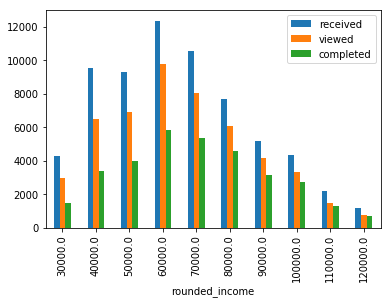

In [36]:
# Customer income vs offers completed
df = customer_data[['rounded_income', 'received', 'viewed', 'completed']]
stats_by_income = df.groupby('rounded_income').sum()
print(stats_by_income)
print()
stats_by_income.plot(kind='bar')


'''The data suggests people with an income between 60,000 and 70,000 are completing offers more frequently.
They also view most offers. However, people with income group between 110,000 to 120,000 completes most offer they view. '''

'Discount offers get completed more often, even though BOGO offers are viewed more. \nIn some income ranges, discounts are completed without having viewed the offer'

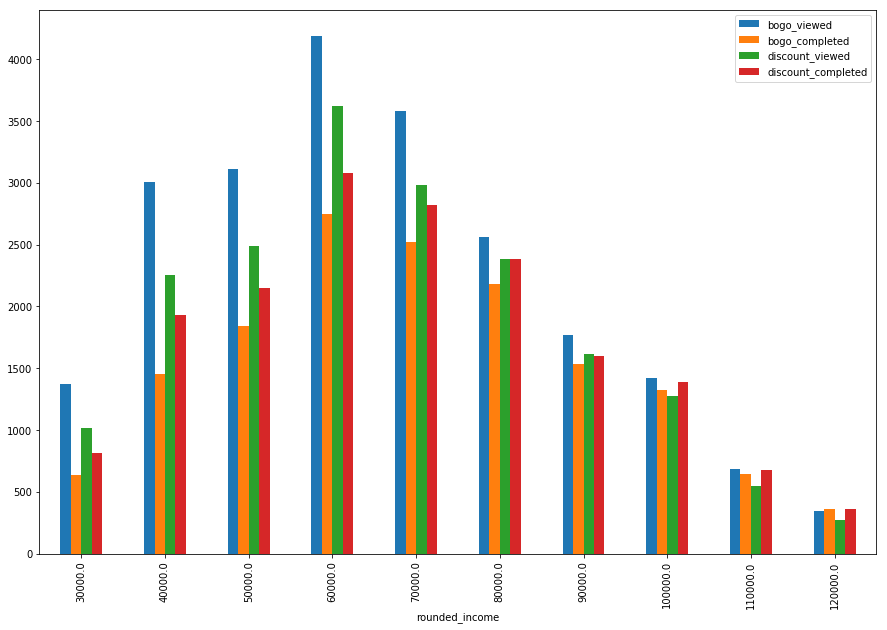

In [37]:
# Customer income vs different offers completed
df = customer_data[['rounded_income', 'bogo_viewed', 'bogo_completed', 'discount_viewed', 'discount_completed']]
stats_by_income = df.groupby('rounded_income').sum()
stats_by_income
print()
stats_by_income.plot(kind='bar', figsize=(15,10))
'''Discount offers get completed more often, even though BOGO offers are viewed more. 
In some income ranges, discounts are completed without having viewed the offer'''

'\nDISCOUNT3 was viewed and completed the most, but DISCOUNT1 has a much higher completion ratio.\nDISCOUNT2 and DISCOUNT3 has the same level of completion ratio throughout the income groups.\nPeople in the higher income group seems to complete DISCOUNT1 without viewing the offer.\n'

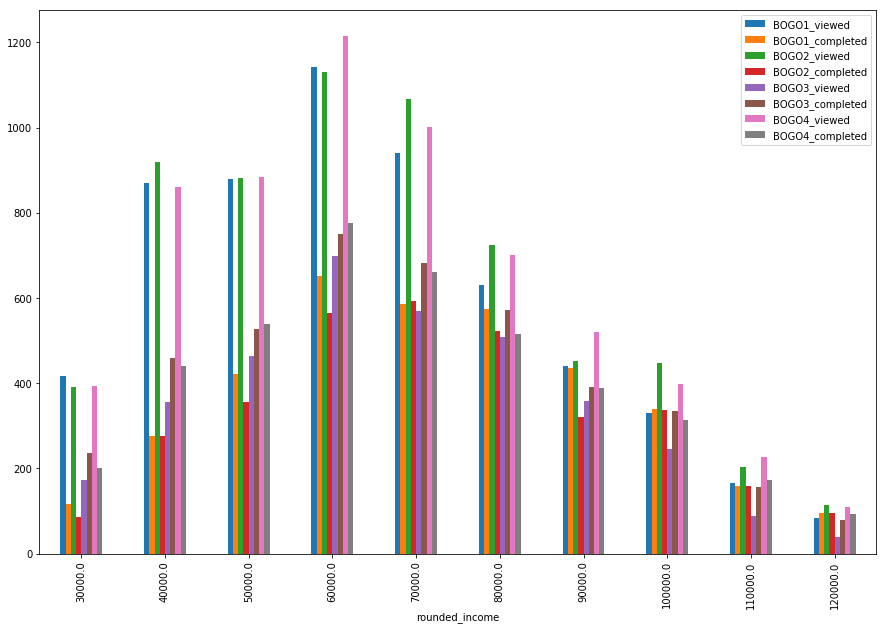

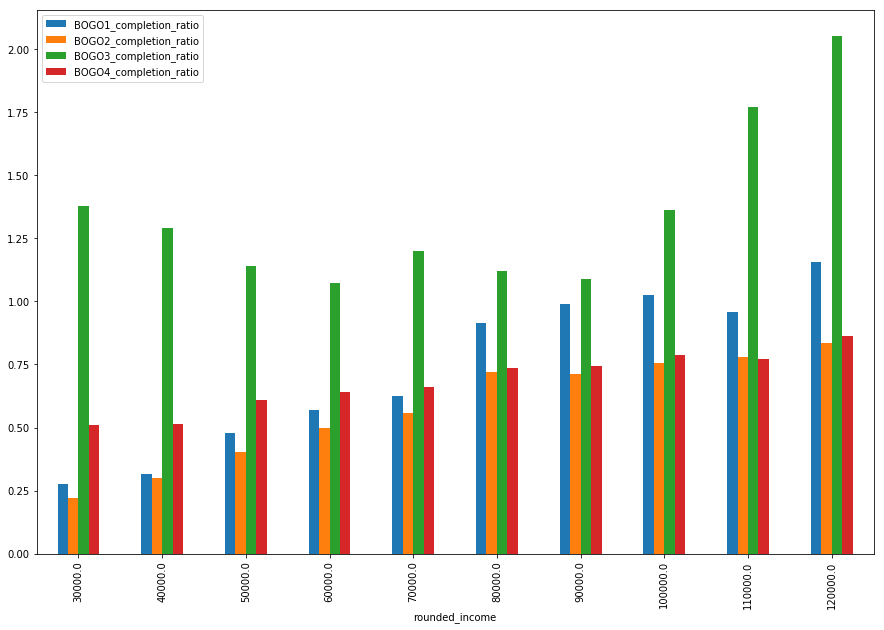

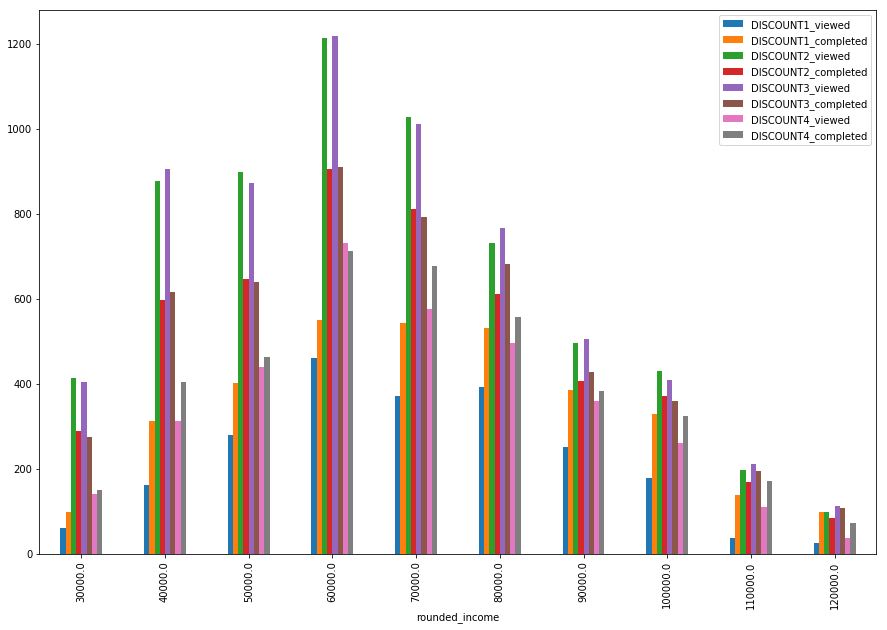

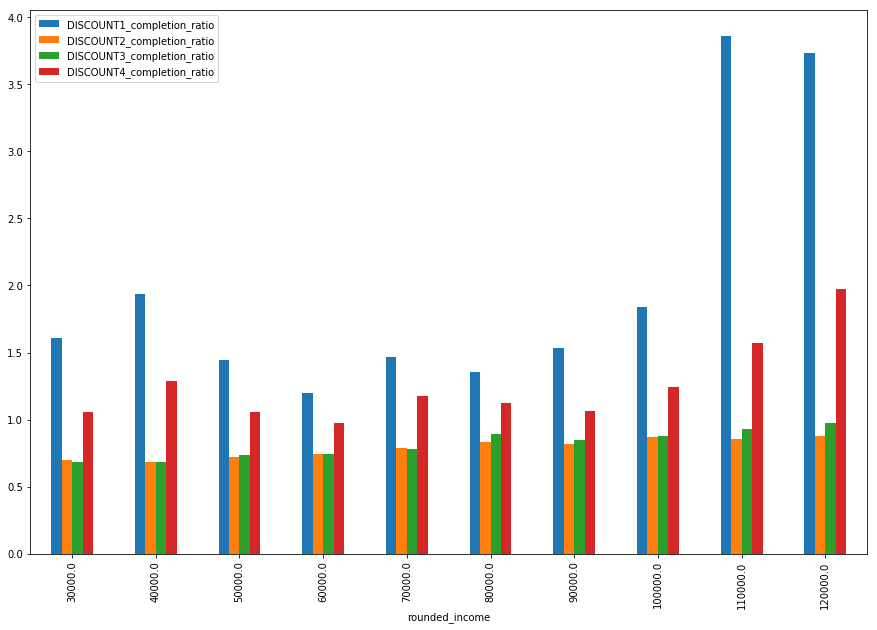

In [38]:
# Customer income vs BOGO and DISCOUNT offers (drill down view)
'''
    'BOGO1',     # [email, mobile, social]
    'BOGO2',     # All channels
    'BOGO3',     # [web, email, mobile]
    'BOGO4',     # All channels
    'DISCOUNT1', # [web, email]
    'DISCOUNT2', # All channels
    'DISCOUNT3', # All channels
    'DISCOUNT4', # [web, email, mobile]
'''


df_bogo = customer_data[['rounded_income', 
                    'BOGO1_viewed', 'BOGO1_completed', 'BOGO2_viewed', 'BOGO2_completed', 
                    'BOGO3_viewed', 'BOGO3_completed', 'BOGO4_viewed', 'BOGO4_completed']]
bogo_stats_by_income = df_bogo.groupby('rounded_income').sum()
bogo_stats_by_income.plot(kind='bar', figsize=(15,10))
print()
bogo_stats_by_income['BOGO1_completion_ratio'] = bogo_stats_by_income['BOGO1_completed']/bogo_stats_by_income['BOGO1_viewed']
bogo_stats_by_income['BOGO2_completion_ratio'] = bogo_stats_by_income['BOGO2_completed']/bogo_stats_by_income['BOGO2_viewed']
bogo_stats_by_income['BOGO3_completion_ratio'] = bogo_stats_by_income['BOGO3_completed']/bogo_stats_by_income['BOGO3_viewed']
bogo_stats_by_income['BOGO4_completion_ratio'] = bogo_stats_by_income['BOGO4_completed']/bogo_stats_by_income['BOGO4_viewed']

bogo_ratio_stats_by_income = bogo_stats_by_income.drop(['BOGO1_viewed', 'BOGO1_completed', 'BOGO2_viewed', 'BOGO2_completed', 
                    'BOGO3_viewed', 'BOGO3_completed', 'BOGO4_viewed', 'BOGO4_completed'], axis=1);
bogo_ratio_stats_by_income.plot(kind='bar', figsize=(15,10))

'''
BOGO4 had the highest views and completions. 
This was advertised on all channels and also had a low difficulty.
BOGO3 has the highest completion to views ratio. 
'''
# print()

df_discount = customer_data[['rounded_income', 
                    'DISCOUNT1_viewed', 'DISCOUNT1_completed', 'DISCOUNT2_viewed', 'DISCOUNT2_completed', 
                    'DISCOUNT3_viewed', 'DISCOUNT3_completed', 'DISCOUNT4_viewed', 'DISCOUNT4_completed']]
discount_stats_by_income = df_discount.groupby('rounded_income').sum()
discount_stats_by_income.plot(kind='bar', figsize=(15,10))

discount_stats_by_income['DISCOUNT1_completion_ratio'] = discount_stats_by_income['DISCOUNT1_completed']/discount_stats_by_income['DISCOUNT1_viewed']
discount_stats_by_income['DISCOUNT2_completion_ratio'] = discount_stats_by_income['DISCOUNT2_completed']/discount_stats_by_income['DISCOUNT2_viewed']
discount_stats_by_income['DISCOUNT3_completion_ratio'] = discount_stats_by_income['DISCOUNT3_completed']/discount_stats_by_income['DISCOUNT3_viewed']
discount_stats_by_income['DISCOUNT4_completion_ratio'] = discount_stats_by_income['DISCOUNT4_completed']/discount_stats_by_income['DISCOUNT4_viewed']

discount_ratio_stats_by_income = discount_stats_by_income.drop(['DISCOUNT1_viewed', 'DISCOUNT1_completed', 
                                                            'DISCOUNT2_viewed', 'DISCOUNT2_completed', 
                                                            'DISCOUNT3_viewed', 'DISCOUNT3_completed', 
                                                            'DISCOUNT4_viewed', 'DISCOUNT4_completed'], axis=1);
discount_ratio_stats_by_income.plot(kind='bar', figsize=(15,10))

'''
DISCOUNT3 was viewed and completed the most, but DISCOUNT1 has a much higher completion ratio.
DISCOUNT2 and DISCOUNT3 has the same level of completion ratio throughout the income groups.
People in the higher income group seems to complete DISCOUNT1 without viewing the offer.
'''

                event_offer_successful
rounded_income                        
30000.0                           1472
40000.0                           3330
50000.0                           3955
60000.0                           5869
70000.0                           5210
80000.0                           4323
90000.0                           2951
100000.0                          2464
110000.0                          1157
120000.0                           634



'The data suggests people with an income between 60,000 and 70,000 are completing offers more successfully.'

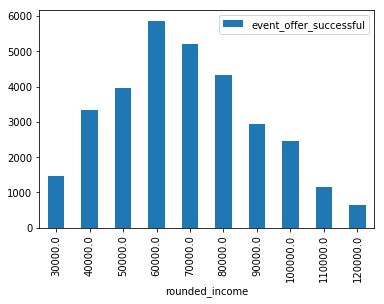

In [39]:
# Customer income vs offers completed successfully
df = customer_data[['rounded_income', 'event_offer_successful']]
stats_by_income = df.groupby('rounded_income').sum()
print(stats_by_income)
print()
stats_by_income.plot(kind='bar')


'''The data suggests people with an income between 60,000 and 70,000 are completing offers more successfully.'''

## Findings:
1. Customers with 60,000 - 70,000 range are completing offers more successfully. They also view the most number of offers.
2. Discount offers get completed more often, even though BOGO offers are viewed more. In some income ranges, discounts are completed without having viewed the offer.
3. DISCOUNT3 was viewed and completed the most, but DISCOUNT1 has a much higher completion ratio.
4. DISCOUNT2 and DISCOUNT3 has the same level of completion ratio throughout the income groups. People in the higher income group seems to complete DISCOUNT1 without viewing the offer.
5. BOGO3 has the highest completion ratio out of all the BOGO offers.

# How does age impact offers
In this section we will see how customer age groups impact offer completion. To make things simpler, the age column is rounded to nearest 10s.

             received   viewed  completed
rounded_age                              
20             4543.0   3140.0     1704.0
30             5623.0   3884.0     2239.0
40             9398.0   7321.0     4384.0
50            12401.0   9484.0     6204.0
60            16722.0  12621.0     8714.0
70             9735.0   7309.0     4952.0
80             5794.0   4419.0     3046.0
90             1974.0   1451.0     1029.0
100             311.0    231.0      172.0



'The age group between 50 to 60 has viewed and completed most offers.'

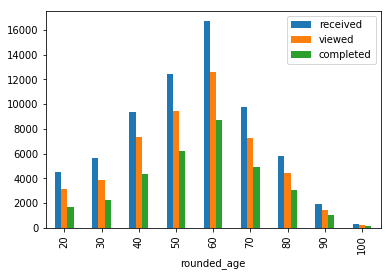

In [40]:
# Customer age groups vs offers completed
df = customer_data[['rounded_age', 'received', 'viewed', 'completed']]
stats_by_age = df.groupby('rounded_age').sum()
print(stats_by_age)
print()
stats_by_age.plot(kind='bar')

'''The age group between 50 to 60 has viewed and completed most offers.'''

,rounded_income,min,max
rounded_age,,,
20,50247.035573,30000.0,80000.0
30,50956.591640,30000.0,80000.0
40,58447.619048,30000.0,100000.0
50,67831.715210,30000.0,120000.0
60,70591.891892,30000.0,120000.0
70,70220.689655,30000.0,120000.0
80,71798.616449,30000.0,120000.0
90,70778.032037,30000.0,120000.0
100,71857.142857,30000.0,120000.0


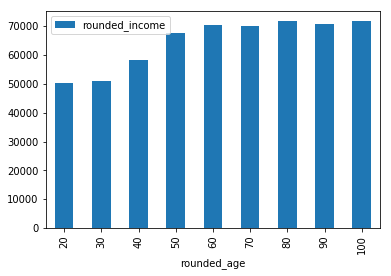

In [41]:
df = customer_data[['rounded_age', 'rounded_income']]

income_and_age = df.groupby('rounded_age').mean()
income_and_age.plot(kind='bar')

income_and_age['min'] = df.groupby('rounded_age').min()
income_and_age['max'] = df.groupby('rounded_age').max()
income_and_age


             event_offer_successful
rounded_age                        
20                             1655
30                             2189
40                             4418
50                             6009
60                             8345
70                             4723
80                             2908
90                              954
100                             164



'The age group between 50 to 60 has viewed and completed most offers successfully.'

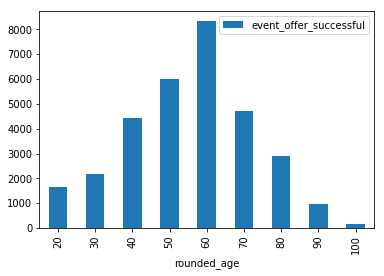

In [42]:
# Customer age groups vs offers completed
df = customer_data[['rounded_age', 'event_offer_successful']]
stats_by_age = df.groupby('rounded_age').sum()
print(stats_by_age)
print()
stats_by_age.plot(kind='bar')

'''The age group between 50 to 60 has viewed and completed most offers successfully.'''

## Findings:
1. Age group between 50 to 100 has the sme income distribution
2. The age group between 50 to 60 has viewed and completed most offers
3. The most successful completion comes from the age group of 60, followed by 50.

# How does Gender impact offers
In this section we look at how gender influences customers to complete offers.

,total_expense,total_transactions,received,viewed,completed,reward,bogo_received,bogo_viewed,bogo_completed,bogo_reward,discount_received,discount_viewed,discount_completed,discount_reward,informational_received,informational_viewed,BOGO1_received,BOGO1_viewed,BOGO1_completed,BOGO1_reward,BOGO2_received,BOGO2_viewed,BOGO2_completed,BOGO2_reward,BOGO3_received,BOGO3_viewed,BOGO3_completed,BOGO3_reward,BOGO4_received,BOGO4_viewed,BOGO4_completed,BOGO4_reward,DISCOUNT1_received,DISCOUNT1_viewed,DISCOUNT1_completed,DISCOUNT1_reward,DISCOUNT2_received,DISCOUNT2_viewed,DISCOUNT2_completed,DISCOUNT2_reward,DISCOUNT3_received,DISCOUNT3_viewed,DISCOUNT3_completed,DISCOUNT3_reward,DISCOUNT4_received,DISCOUNT4_viewed,DISCOUNT4_completed,DISCOUNT4_reward,INFO1_received,INFO1_viewed,INFO2_received,INFO2_viewed,age,gender_F,gender_M,gender_O,became_member_on_year,became_member_on_month,income,outlier,rounded_age,rounded_income,net_expense,event_offer_successful
gender,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F,863507.99,49366.0,27456.0,20786.0,15477.0,78787.0,10975.0,9143.0,7501.0,55520.0,10943.0,7733.0,7976.0,23267.0,5538.0,3910.0,2750.0,2364.0,1857.0,18570.0,2737.0,2623.0,1746.0,17460.0,2767.0,1544.0,1999.0,9995.0,2721.0,2612.0,1899.0,9495.0,2801.0,982.0,1703.0,8515.0,2718.0,2614.0,2206.0,6618.0,2696.0,2608.0,2216.0,4432.0,2728.0,1529.0,1851.0,3702.0,2749.0,1515.0,2789.0,2395.0,352446,6125.0,0.0,0.0,12351883,41846,436808000.0,0,352080,437040000.0,784720.99,14583
M,844827.61,72791.0,38129.0,28301.0,16466.0,79241.0,15208.0,12581.0,7512.0,53860.0,15354.0,10431.0,8954.0,25381.0,7567.0,5289.0,3840.0,3454.0,1741.0,17410.0,3784.0,3635.0,1519.0,15190.0,3817.0,1879.0,2115.0,10575.0,3767.0,3613.0,2137.0,10685.0,3826.0,1179.0,1620.0,8100.0,3845.0,3675.0,2613.0,7839.0,3868.0,3711.0,2721.0,5442.0,3815.0,1866.0,2000.0,4000.0,3812.0,1902.0,3755.0,3387.0,442067,0.0,8483.0,0.0,17106884,55970,519105000.0,0,441600,518450000.0,765586.61,16273
O,26356.54,1781.0,916.0,773.0,501.0,2513.0,354.0,315.0,245.0,1745.0,367.0,297.0,256.0,768.0,195.0,161.0,93.0,83.0,59.0,590.0,72.0,71.0,45.0,450.0,101.0,76.0,74.0,370.0,88.0,85.0,67.0,335.0,99.0,54.0,63.0,315.0,92.0,90.0,67.0,201.0,88.0,88.0,66.0,132.0,88.0,65.0,60.0,120.0,96.0,70.0,99.0,91.0,11533,0.0,0.0,212.0,427545,1408,13417000.0,0,11590,13420000.0,23843.54,509


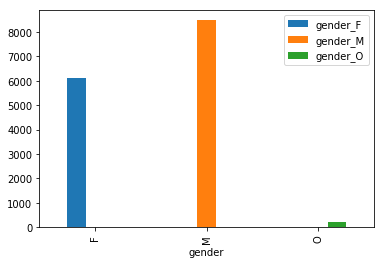

In [43]:
# Gender in the dataset
gender_df = customer_data.groupby('gender').sum()
gender_df[['gender_F', 'gender_M', 'gender_O']].plot(kind='bar')
'''
The dataset has an uneven number of males and females. With such low data on 'Other' gender, this can be ignored.
'''
gender_df

'\nEven though males tend to receve and view more offers, the offer completion between female and male tend to be the same\n'

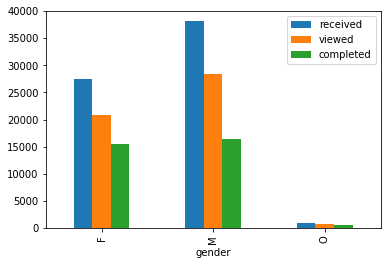

In [44]:
gender_df[['received', 'viewed', 'completed']].plot(kind='bar')
'''
Even though males tend to receve and view more offers, the offer completion between female and male tend to be the same
'''

'\nBoth BOGO and DISCOUNT offers are availed almost equally by females. The data suggests males go more for DISCOUNT offers.\n'

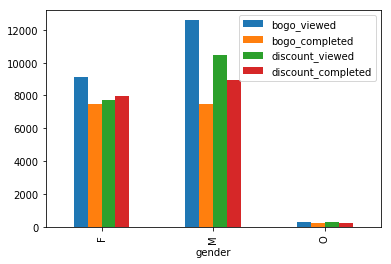

In [45]:
gender_df[['bogo_viewed', 'bogo_completed', 'discount_viewed', 'discount_completed']].plot(kind='bar')
'''
Both BOGO and DISCOUNT offers are availed almost equally by females. The data suggests males go more for DISCOUNT offers.
'''

'\nOffer completion rate is higher in females compared to males especially when it comes to BOGO3.\n'

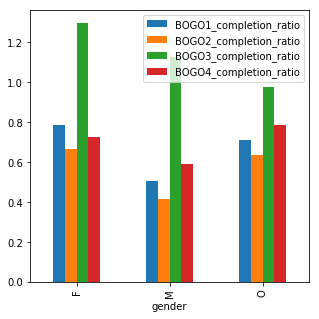

In [46]:
gender_df['BOGO1_completion_ratio'] = gender_df['BOGO1_completed']/gender_df['BOGO1_viewed']
gender_df['BOGO2_completion_ratio'] = gender_df['BOGO2_completed']/gender_df['BOGO2_viewed']
gender_df['BOGO3_completion_ratio'] = gender_df['BOGO3_completed']/gender_df['BOGO3_viewed']
gender_df['BOGO4_completion_ratio'] = gender_df['BOGO4_completed']/gender_df['BOGO4_viewed']

gender_df[['BOGO1_completion_ratio', 'BOGO2_completion_ratio', 'BOGO3_completion_ratio', 'BOGO4_completion_ratio']].plot(kind='bar', figsize=(5,5))

'''
Offer completion rate is higher in females compared to males especially when it comes to BOGO3.
'''

'\nDISCOUNT1 is completed most of the time, sometimes without even viewing.\n'

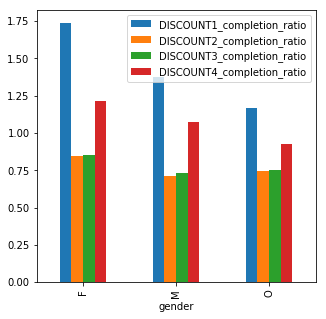

In [47]:
gender_df['DISCOUNT1_completion_ratio'] = gender_df['DISCOUNT1_completed']/gender_df['DISCOUNT1_viewed']
gender_df['DISCOUNT2_completion_ratio'] = gender_df['DISCOUNT2_completed']/gender_df['DISCOUNT2_viewed']
gender_df['DISCOUNT3_completion_ratio'] = gender_df['DISCOUNT3_completed']/gender_df['DISCOUNT3_viewed']
gender_df['DISCOUNT4_completion_ratio'] = gender_df['DISCOUNT4_completed']/gender_df['DISCOUNT4_viewed']

gender_df[['DISCOUNT1_completion_ratio', 'DISCOUNT2_completion_ratio', 'DISCOUNT3_completion_ratio', 'DISCOUNT4_completion_ratio']].plot(kind='bar', figsize=(5,5))

'''
DISCOUNT1 is completed most of the time, sometimes without even viewing.
'''


'\nThe data shows males completing offers more successfully. This may be because females recieving less offers.\n'

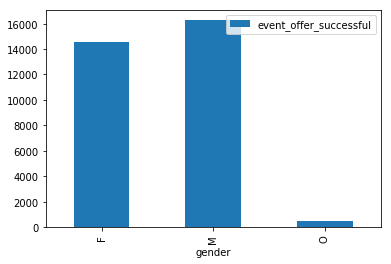

In [48]:
gender_df[['event_offer_successful']].plot(kind='bar')
'''
The data shows males completing offers more successfully. This may be because females recieving less offers.
'''

## Findings
1. The dataset contains an uneven number of female, males and others. The others are too little compared to females/males, so it can be dropped.
2. Even though males tend to receive and view more offers, the offer completion between female and male tend to be the same
3. Both BOGO and DISCOUNT offers are availed almost equally by females. The data suggests males go more for DISCOUNT offers.
4. BOGO offer completion rate is higher in females compared to males especially when it comes to BOGO3.
5. DISCOUNT1 is completed most of the time, sometimes without even viewing by Females.


# Does Membership start date impact offers

'\nCustomers who became members in 2017 appears to be more active when it comes to offers. \nEspecially those who became members towards the end of 2017.\n'

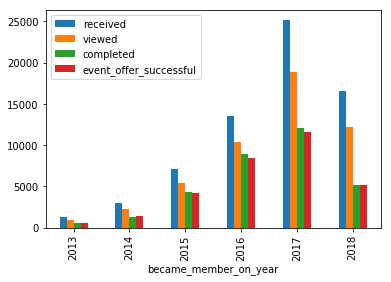

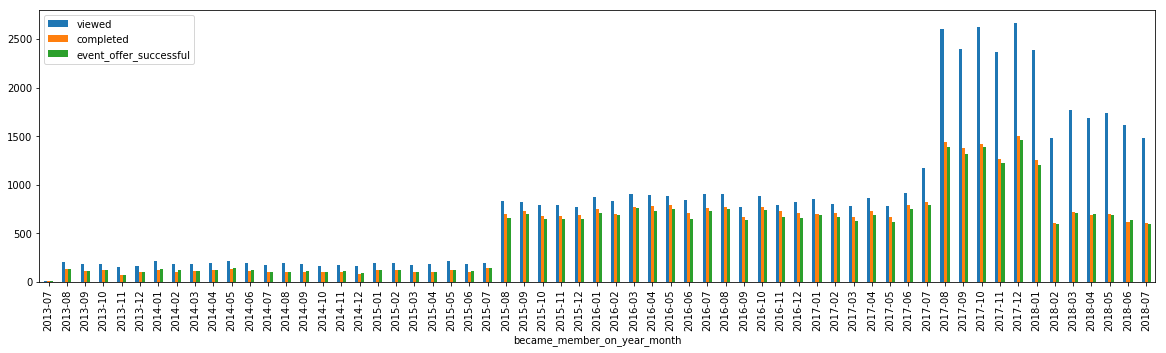

In [49]:
# Membership start date feature study
df = customer_data[['became_member_on_year', 'received', 'viewed', 'completed', 'event_offer_successful']]
stats_by_membership_year = df.groupby('became_member_on_year').sum()
stats_by_membership_year.plot(kind='bar')


df = customer_data[['became_member_on_year_month', 'viewed', 'completed', 'event_offer_successful']]
stats_by_membership_date = df.groupby('became_member_on_year_month').sum()
stats_by_membership_date.plot(kind='bar', figsize=(20,5))

'''
Customers who became members in 2017 appears to be more active when it comes to offers. 
Especially those who became members towards the end of 2017.
'''

,rounded_income
became_member_on_year,
2013,57883.211679
2014,58157.099698
2015,67017.543860
2016,70592.127026
2017,65659.399571
2018,61804.306351


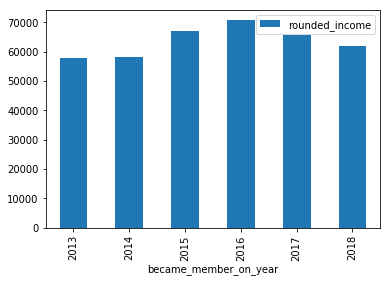

In [50]:
df = customer_data[['became_member_on_year', 'rounded_income']]
customer_stats_by_membership_year = df.groupby('became_member_on_year').mean()

customer_stats_by_membership_year.plot(kind='bar')

customer_stats_by_membership_year

## Findings
1. Members who joined in 2017 appears to have completed more offers.This is because they received the most offers
2. There is a spike in offer views and offers completed in members who joined between late 2017 and early 2018

# Prepare data for machine learning modelling
Data for ML pipeline will be prepared. The target is to predict if a customer successfully avails an offer. Data is preprocessed before applying MinMaxScaler. Columns like gender and offer_type are mapped to integer values

In [51]:
# Prepare data for ml pipeline

modelling_data = success_data[['customer_id', 'time', 'age', 'became_member_on', 
             'became_member_on_month' , 'gender', 'income', 
             'offer_id', 'offer_type', 'reward', 'bogo', 'discount', 'informational', 
             'email', 'social', 'web', 'mobile', 'duration', 'event_offer_successful',
             'difficulty', 'outlier']]
modelling_data = modelling_data[modelling_data['outlier'] == 0]

gender_map = {'M': 1, 'F': 0}
modelling_data['gender'] = modelling_data['gender'].map(gender_map)
modelling_data = modelling_data[modelling_data['gender'].notna()]


offer_map = {'bogo': 1, 'informational': 2, 'discount': 3}
modelling_data['offer_type'] = modelling_data['offer_type'].map(offer_map)
modelling_data['member_for_days'] = datetime.today() - modelling_data['became_member_on']
modelling_data['member_for_days'] = modelling_data['member_for_days'].dt.days
modelling_data = modelling_data.drop(['offer_id', 'outlier', 'customer_id', 'became_member_on', 
                                     'became_member_on_month'], axis=1)


print('Data shape: ' + str(modelling_data.shape))
modelling_data = modelling_data.sample(frac=1)

modelling_data.head(5)

Data shape: (65585, 17)


,time,age,gender,income,offer_type,reward,bogo,discount,informational,email,social,web,mobile,duration,event_offer_successful,difficulty,member_for_days
44014,168,73,1.0,32000.0,1,5,1,0,0,1,1,1,1,120,1,5,1063
10507,576,57,1.0,72000.0,3,2,0,1,0,1,0,1,1,168,1,10,1324
56522,0,47,1.0,31000.0,2,0,0,0,1,1,0,1,1,96,0,0,991
3617,576,90,0.0,71000.0,2,0,0,0,1,1,0,1,1,96,1,0,866
75402,336,67,0.0,34000.0,3,3,0,1,0,1,1,1,1,168,1,7,1905


Data is scaled down to range of 0 to 1

In [52]:
# scale numerical features into a normalized range, 0-1
scaler=MinMaxScaler()

# store them in this dataframe
scaled_df = pd.DataFrame(scaler.fit_transform(modelling_data.astype(float)))

# get same features and indices
scaled_df.columns = modelling_data.columns
scaled_df.index = modelling_data.index

scaled_df.tail(5)

,time,age,gender,income,offer_type,reward,bogo,discount,informational,email,social,web,mobile,duration,event_offer_successful,difficulty,member_for_days
41554,0.875000,0.457831,1.0,0.377778,0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.142857,0.0,0.00,0.124520
21375,1.000000,0.192771,1.0,0.088889,0.0,0.5,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.285714,1.0,0.25,0.224904
24561,0.291667,0.987952,0.0,0.188889,1.0,0.2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.571429,1.0,0.50,0.132748
7588,0.875000,0.602410,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.571429,1.0,0.50,0.059243
65134,0.583333,0.481928,0.0,0.577778,0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.142857,0.0,0.00,0.526056


In [53]:
y = scaled_df.filter(['event_offer_successful'])
X = scaled_df.drop(['event_offer_successful'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3, random_state = 42)
print('X_train size: ' + str(X_train.shape))
print('X_test size: ' + str(X_test.shape))

X_train size: (45909, 16)
X_test size: (19676, 16)


In [54]:
y_train = y_train.ravel()
y_test = y_test.ravel()

The naive accuracy scores gives us an worst case target to aim at

In [55]:
naive_predictor_accuracy = accuracy_score(y_train, np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: " + str(naive_predictor_accuracy))
print("Naive predictor f1-score: " + str(naive_predictor_f1score))

Naive predictor accuracy: 0.470060336753
Naive predictor f1-score: 0.639511624117


In [56]:
def evaluate_model_performance(clf, X_train, y_train):
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    print("%s model accuracy: %.3f" % (class_name, accuracy_score(y_train, y_pred_rf)))
    print("%s model f1-score: %.3f" % (class_name, f1_score(y_train, y_pred_rf)))
    

In [57]:
def feature_plot(importances, columns):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = columns.values[indices[:7]]
    print(indices)
    values = importances[indices][:7]
    print('Importances: '+ str(values))
    # Creat the plot
    fig = plt.figure(figsize = (12,5))
    plt.title("Normalized Weights for First 7 Most Predictive Features", fontsize = 10)
    plt.bar(np.arange(7), values, width = 0.2, align="center", color = '#99ff33', \
          label = "Feature Weight")
    plt.bar(np.arange(7) - 0.2, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(7), columns)
    plt.xlim((-0.5, 7.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()

## Logistic Regression
The first model that was trained was logistic regression. This will give us a better benchmark to target 

In [58]:
# Logistic Regression

scorer = make_scorer(fbeta_score, beta=0.5)

lr_clf = LogisticRegression(random_state=42, solver='liblinear')

C_range = np.random.normal(1, 0.2, 10).astype(float)
C_range[C_range < 0] = 0.0001

param_distributions = dict(C=C_range,
                     penalty=['l2', 'l1'])

lr_random = RandomizedSearchCV(
    estimator = lr_clf, 
    param_distributions = param_distributions, 
    scoring=scorer, 
    n_iter = 15, 
    cv = 3, 
    verbose=1, 
    random_state=42, 
    n_jobs = 2)

# fit train data to the model for benchmark
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
# Improved model
lr_random.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed:  3.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=15, n_jobs=2,
          param_distributions={'C': array([ 1.166  ,  0.97942,  0.98918,  1.32285,  1.18753,  0.67103,
        1.39171,  0.8776 ,  0.87012,  1.05798]), 'penalty': ['l2', 'l1']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=1)

In [61]:
# BENCHMARK SCORES
evaluate_model_performance(lr_random.best_estimator_, X_train, y_train)

LogisticRegression model accuracy: 0.711
LogisticRegression model f1-score: 0.704


## Logistic Regression: Findings
It was possible to get an accuracy of above 70% with a simple logistic regression model. 

## SVM

In [62]:
# SVM
svc_clf = svm.SVC(random_state=42)

g_range = np.random.uniform(0.2, 0.3, 1).astype(float)
C_range = np.random.normal(1, 0.1, 5).astype(float)

param_distributions = {'C': C_range, 
                       'kernel': ['poly'], 
                       'gamma': g_range,
                       'degree': [4, 5]
                      }
                       

svc_random = RandomizedSearchCV(estimator = svc_clf,
                               param_distributions = param_distributions,
                               n_iter = 6,
                               cv = 5,
                               verbose=2,
                               random_state = 42,
                               n_jobs = 4)
# Training ~ 30 mins
svc_random.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] kernel=poly, gamma=0.267216034891, degree=4, C=1.11736565366 ....
[CV] kernel=poly, gamma=0.267216034891, degree=4, C=1.11736565366 ....
[CV] kernel=poly, gamma=0.267216034891, degree=4, C=1.11736565366 ....
[CV] kernel=poly, gamma=0.267216034891, degree=4, C=1.11736565366 ....
[CV]  kernel=poly, gamma=0.267216034891, degree=4, C=1.11736565366, total= 2.9min
[CV] kernel=poly, gamma=0.267216034891, degree=4, C=1.11736565366 ....
[CV]  kernel=poly, gamma=0.267216034891, degree=4, C=1.11736565366, total= 2.9min
[CV] kernel=poly, gamma=0.267216034891, degree=5, C=0.937427684425 ...
[CV]  kernel=poly, gamma=0.267216034891, degree=4, C=1.11736565366, total= 2.9min
[CV] kernel=poly, gamma=0.267216034891, degree=5, C=0.937427684425 ...
[CV]  kernel=poly, gamma=0.267216034891, degree=4, C=1.11736565366, total= 2.9min
[CV] kernel=poly, gamma=0.267216034891, degree=5, C=0.937427684425 ...
[CV]  kernel=poly, gamma=0.267216034891, deg

KeyboardInterrupt: 

In [ ]:
evaluate_model_performance(svc_random.best_estimator_, X_train, y_train)
print(svc_random.best_params_)

## Random Forest
Random Forest is the next classifier for our trial with the number of max trees of 300.

In [104]:
# Random Forest

rf_clf = RandomForestClassifier(random_state=42)

# Number of trees in random forest
n_estimators = [200, 250, 300, 400]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(10, 15)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 7, 13]

# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 7, 10]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tune the classifer
rf_random = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 4)

# fit train data to the classifier
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=200, min_samples_split=7, min_samples_leaf=10, max_features=sqrt, max_depth=None 
[CV] n_estimators=200, min_samples_split=7, min_samples_leaf=10, max_features=sqrt, max_depth=None 
[CV] n_estimators=200, min_samples_split=7, min_samples_leaf=10, max_features=sqrt, max_depth=None 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=11 
[CV]  n_estimators=200, min_samples_split=7, min_samples_leaf=10, max_features=sqrt, max_depth=None, total=  29.1s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=11 
[CV]  n_estimators=200, min_samples_split=7, min_samples_leaf=10, max_features=sqrt, max_depth=None, total=  29.3s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=11 
[CV]  n_estimators=200, min_samples_split=7, min_samples_leaf=10, max_features=sqrt, max_depth=None, total=  29.2s
[

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  6.3min


[CV]  n_estimators=300, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=10, total=  36.2s
[CV] n_estimators=400, min_samples_split=7, min_samples_leaf=7, max_features=sqrt, max_depth=12 
[CV]  n_estimators=300, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=10, total=  36.7s
[CV] n_estimators=400, min_samples_split=7, min_samples_leaf=7, max_features=sqrt, max_depth=12 
[CV]  n_estimators=300, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=10, total=  37.0s
[CV] n_estimators=300, min_samples_split=13, min_samples_leaf=5, max_features=sqrt, max_depth=14 
[CV]  n_estimators=400, min_samples_split=7, min_samples_leaf=7, max_features=sqrt, max_depth=12, total=  54.1s
[CV] n_estimators=300, min_samples_split=13, min_samples_leaf=5, max_features=sqrt, max_depth=14 
[CV]  n_estimators=400, min_samples_split=7, min_samples_leaf=7, max_features=sqrt, max_depth=12, total=  54.0s
[CV] n_estimators=300, min_samples_split=13,

[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=14, total=  36.9s
[CV] n_estimators=400, min_samples_split=13, min_samples_leaf=5, max_features=sqrt, max_depth=14 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=14, total=  36.9s
[CV] n_estimators=400, min_samples_split=13, min_samples_leaf=5, max_features=sqrt, max_depth=14 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=14, total=  36.8s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=7, max_features=auto, max_depth=12 
[CV]  n_estimators=400, min_samples_split=13, min_samples_leaf=5, max_features=sqrt, max_depth=14, total=  58.7s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=7, max_features=auto, max_depth=12 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=7, max_features=auto, max_depth=12, total=  34.3s
[CV] n_estimators=250, min_samples_split=5, min_s

[CV]  n_estimators=300, min_samples_split=5, min_samples_leaf=7, max_features=auto, max_depth=None, total=  46.4s
[CV] n_estimators=300, min_samples_split=13, min_samples_leaf=10, max_features=auto, max_depth=14 
[CV]  n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=11, total=  26.0s
[CV] n_estimators=300, min_samples_split=13, min_samples_leaf=10, max_features=auto, max_depth=14 
[CV]  n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=11, total=  26.2s
[CV] n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=None 
[CV]  n_estimators=300, min_samples_split=13, min_samples_leaf=10, max_features=auto, max_depth=14, total=  42.6s
[CV] n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=None 
[CV]  n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=None, total=  29.1s
[CV] n_estimators=200, min_s

[CV]  n_estimators=400, min_samples_split=7, min_samples_leaf=7, max_features=auto, max_depth=None, total= 1.0min
[CV] n_estimators=300, min_samples_split=13, min_samples_leaf=7, max_features=auto, max_depth=13 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=7, max_features=auto, max_depth=10, total=  50.6s
[CV] n_estimators=300, min_samples_split=13, min_samples_leaf=7, max_features=auto, max_depth=13 
[CV]  n_estimators=300, min_samples_split=13, min_samples_leaf=7, max_features=auto, max_depth=13, total=  42.9s
[CV] n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=14 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=7, max_features=auto, max_depth=10, total=  49.9s
[CV] n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=14 


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 29.7min


[CV]  n_estimators=300, min_samples_split=13, min_samples_leaf=7, max_features=auto, max_depth=13, total=  42.6s
[CV] n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=14 
[CV]  n_estimators=300, min_samples_split=13, min_samples_leaf=7, max_features=auto, max_depth=13, total=  42.6s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=14, total=  28.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=14, total=  28.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=5, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=14, total=  28.7s
[CV] n_estimators=400, min_samples_split=7

[CV]  n_estimators=400, min_samples_split=7, min_samples_leaf=5, max_features=auto, max_depth=None, total= 1.1min
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=10 
[CV]  n_estimators=400, min_samples_split=7, min_samples_leaf=5, max_features=auto, max_depth=None, total= 1.1min
[CV] n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=auto, max_depth=12 
[CV]  n_estimators=400, min_samples_split=7, min_samples_leaf=5, max_features=auto, max_depth=None, total= 1.1min
[CV] n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=auto, max_depth=12 
[CV]  n_estimators=250, min_samples_split=5, min_samples_leaf=10, max_features=auto, max_depth=10, total=  31.8s
[CV] n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=auto, max_depth=12 
[CV]  n_estimators=200, min_samples_split=13, min_samples_leaf=10, max_features=auto, max_depth=12, total=  28.0s
[CV] n_estimators=200, min_samples_s

[CV]  n_estimators=300, min_samples_split=13, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  37.2s
[CV] n_estimators=200, min_samples_split=7, min_samples_leaf=10, max_features=auto, max_depth=12 
[CV]  n_estimators=300, min_samples_split=13, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=  37.0s
[CV] n_estimators=250, min_samples_split=7, min_samples_leaf=5, max_features=sqrt, max_depth=11 
[CV]  n_estimators=200, min_samples_split=7, min_samples_leaf=10, max_features=auto, max_depth=12, total=  26.9s
[CV] n_estimators=250, min_samples_split=7, min_samples_leaf=5, max_features=sqrt, max_depth=11 
[CV]  n_estimators=200, min_samples_split=7, min_samples_leaf=10, max_features=auto, max_depth=12, total=  26.9s
[CV] n_estimators=250, min_samples_split=7, min_samples_leaf=5, max_features=sqrt, max_depth=11 
[CV]  n_estimators=200, min_samples_split=7, min_samples_leaf=10, max_features=auto, max_depth=12, total=  26.8s
[CV] n_estimators=300, min_samples_split=13, m

[CV]  n_estimators=400, min_samples_split=7, min_samples_leaf=10, max_features=auto, max_depth=10, total=  49.3s
[CV] n_estimators=200, min_samples_split=13, min_samples_leaf=5, max_features=auto, max_depth=14 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=7, max_features=auto, max_depth=11, total=  26.4s
[CV] n_estimators=400, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=13 
[CV]  n_estimators=200, min_samples_split=13, min_samples_leaf=5, max_features=auto, max_depth=14, total=  29.6s
[CV] n_estimators=400, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=13 
[CV]  n_estimators=200, min_samples_split=13, min_samples_leaf=5, max_features=auto, max_depth=14, total=  29.4s
[CV] n_estimators=400, min_samples_split=13, min_samples_leaf=10, max_features=sqrt, max_depth=13 
[CV]  n_estimators=200, min_samples_split=13, min_samples_leaf=5, max_features=auto, max_depth=14, total=  29.3s
[CV] n_estimators=250, min_samples_split=

[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 55.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=4,
          param_distributions={'n_estimators': [200, 250, 300, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 11, 12, 13, 14, None], 'min_samples_split': [5, 7, 13], 'min_samples_leaf': [5, 7, 10]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [105]:
evaluate_model_performance(rf_random.best_estimator_, X_train, y_train)
print(rf_random.best_params_)

RandomForestClassifier model accuracy: 0.786
RandomForestClassifier model f1-score: 0.773
{'n_estimators': 300, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 12}


Index(['time', 'age', 'gender', 'income', 'offer_type', 'reward', 'bogo',
       'discount', 'informational', 'email', 'social', 'web', 'mobile',
       'duration', 'difficulty', 'member_for_days'],
      dtype='object')
[15  3  1  0  8  5 13 14  2 10  7  6 11 12  4  9]
Importances: [ 0.30258541  0.20245668  0.19196979  0.07386501  0.06315842  0.04331843
  0.03937077]


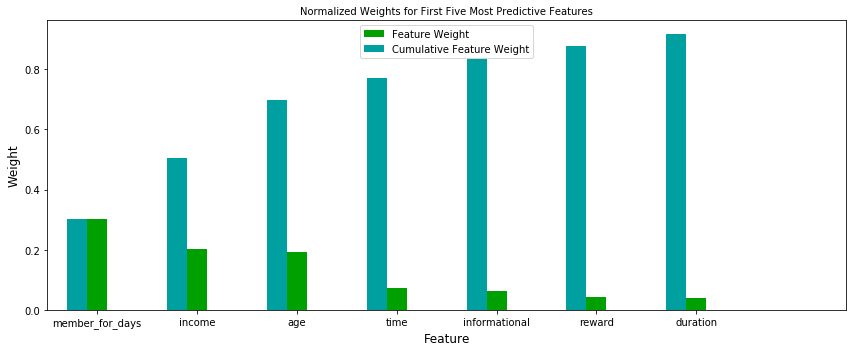

In [106]:
#Extract the feature importances
rf_clf.fit(X_train, y_train)

importances = rf_clf.feature_importances_
print(X.columns)
feature_plot(importances, X.columns)

## Random Forest: Findings
The accuracy is much better (above 77%). 
The important features which were listed were
1. member_for_days
2. income
3. age
4. time
5. information offer

## Decision Trees
We will try decision trees and see if we are able to get a higher accuracy and if the important features are consistent

In [65]:
# Decision Trees
dt_clf = DecisionTreeClassifier(random_state = 42)  

param_dist = {"max_depth": [None],
              "min_samples_leaf": [8, 9, 10, 11],
              "max_features": [11, 12, 13, 14],
              "criterion": ["gini", "entropy"]}

# tune the classifer
dt_random = RandomizedSearchCV(estimator = dt_clf,
                               param_distributions = param_dist,
                               n_iter = 30,
                               n_jobs = 3,
                               scoring = scorer,
                               verbose = 2,
                               cv = 6)

# fit train data to the classifier
dt_random.fit(X_train, y_train)

Fitting 6 folds for each of 30 candidates, totalling 180 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   10.3s
[Parallel(n_jobs=3)]: Done 180 out of 180 | elapsed:   40.0s finished


RandomizedSearchCV(cv=6, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          fit_params=None, iid=True, n_iter=30, n_jobs=3,
          param_distributions={'max_depth': [None], 'min_samples_leaf': [8, 9, 10, 11], 'max_features': [11, 12, 13, 14], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=1)

In [66]:
evaluate_model_performance(dt_random.best_estimator_, X_train, y_train)
print(dt_random.best_params_) # Best: {'min_samples_leaf': 11, 'max_features': 11, 'max_depth': None, 'criterion': 'gini'}

DecisionTreeClassifier model accuracy: 0.807
DecisionTreeClassifier model f1-score: 0.792
{'min_samples_leaf': 11, 'max_features': 12, 'max_depth': None, 'criterion': 'gini'}


[15  1  3  8  0 10  2  5  4 14 13 11  6 12  7  9]
Importances: [ 0.30582978  0.17761919  0.17343186  0.15960982  0.07590505  0.02586478
  0.0187366 ]


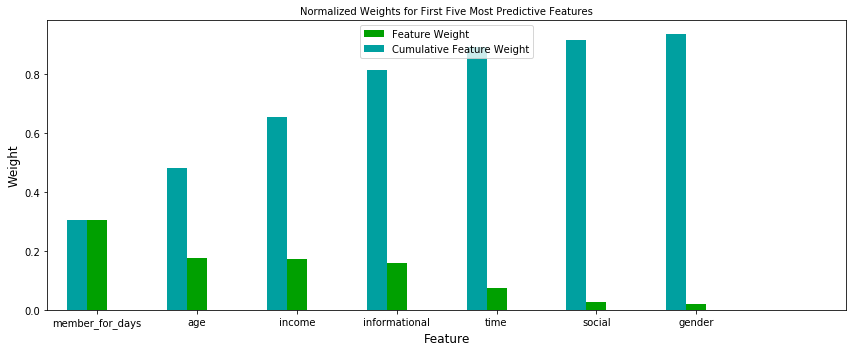

In [67]:
dt_clf.fit(X_train, y_train)
importances = dt_clf.feature_importances_

feature_plot(importances, X.columns)

## Decision Trees: Findings
The accuracy and f1-score is the highest of all the models. 
The features which were given the most importance: 
1. member_for_days
2. income
3. age
4. informational
5. time

## AdaBoost 


In [99]:
# AdaBoost
adaboost_clf = AdaBoostClassifier(dt_random.best_estimator_, random_state=42)

param_distributions = {
 'n_estimators': [75, 100],
 'learning_rate' : [2.1,2.2],
 }

# tune the classifer
adaboost_random = RandomizedSearchCV(estimator = adaboost_clf,
                                     param_distributions = param_distributions,
                                     verbose = 2,
                                     cv = 2, 
                                     n_iter = 2,
                                     n_jobs = 2)

adaboost_random.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] n_estimators=75, learning_rate=2.1 ..............................
[CV] n_estimators=75, learning_rate=2.1 ..............................
[CV] ............... n_estimators=75, learning_rate=2.1, total=  12.4s
[CV] n_estimators=75, learning_rate=2.2 ..............................
[CV] ............... n_estimators=75, learning_rate=2.1, total=  12.5s
[CV] n_estimators=75, learning_rate=2.2 ..............................
[CV] ............... n_estimators=75, learning_rate=2.2, total=  11.2s
[CV] ............... n_estimators=75, learning_rate=2.2, total=  11.5s


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   25.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   25.4s finished


RandomizedSearchCV(cv=2, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=12, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=11, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42),
          fit_params=None, iid=True, n_iter=2, n_jobs=2,
          param_distributions={'n_estimators': [75, 100], 'learning_rate': [2.1, 2.2]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [100]:
evaluate_model_performance(adaboost_random.best_estimator_, X_train, y_train)
print(adaboost_random.best_params_)

AdaBoostClassifier model accuracy: 0.900
AdaBoostClassifier model f1-score: 0.893
{'n_estimators': 75, 'learning_rate': 2.1}


[15  1  3  0  5  2 13 14 10 11  6  7  4 12  8  9]
Importances: [ 0.26900815  0.2093986   0.15009729  0.11014045  0.03609457  0.03157627
  0.02369878]


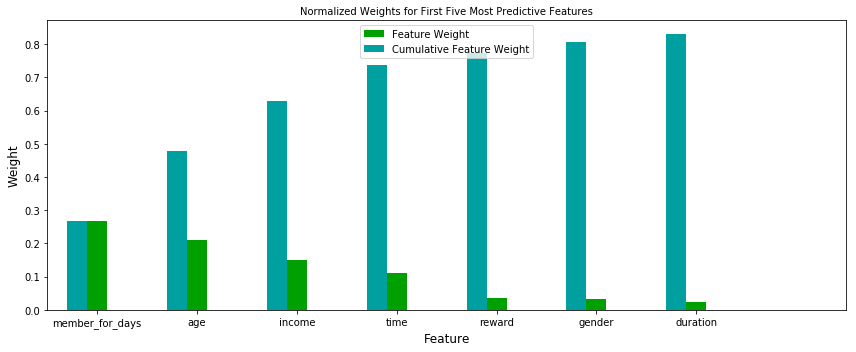

In [103]:
adaboost_clf.fit(X_train, y_train)
importances = adaboost_clf.feature_importances_

feature_plot(importances, X.columns)

## AdaBoost: Findings
It provided a good accuracy score (around 75%). 
The feature importance were similar to previous models: 
1. income
2. member_for_days
3. duration
4. time
5. age